In [90]:
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
import pandas as pd
import glob
import h5py
import re
from tqdm import tqdm
import scipy.io as sio
import os
import pickle
from matplotlib import pyplot as plt
import seaborn as sns
plt.rc('font', size=14)


In [19]:

monkey_names = ["W", "V"]

root_dir = '/Users/f005d7d/Documents/Attn_MdPRL/what-where-task/'
# root_dir = '/dartfs-hpc/scratch/f005d7d/what_where_analysis/'

bhv_path = os.path.join(root_dir, 'Behavior/')
processed_path = os.path.join(root_dir, 'processed/')
neural_path = os.path.join(root_dir, 'RasterVec_binSize_10ms/')

all_sess_regression_info = {
    'aligned_event': [],
    'monkey_name': [],
    'area_name': [],
    'sess_date': [],
    'betas': [],
    'exp_vars': [],
    'pvals': []
}

regressor_names = ['CR_what', 'CR_where', 'WSLS_what', 'WSLS_where']
tbl_col_names = ['type', 'CR_what', 'CR_where', 'WSLS_what', 'WSLS_where']

formula = 'choice~type*('+'+'.join(regressor_names)+')'

In [29]:
all_sess_task_info = []

for monkey_idx, monkey_name in enumerate(monkey_names):
    files = glob.glob(f'{bhv_path}/SPKcounts_{monkey_name}*cue_MW_250X250ms.mat')
    for sess_idx in range(len(files)):
        filename = files[sess_idx]

        sess_date = re.search(re.compile(f'{bhv_path}SPKcounts_{monkey_name}(\\d*)cue_MW_250X250ms.mat'), filename).groups()[0]

        curr_sess_bhv = sio.loadmat(filename)
        task_info = curr_sess_bhv['Y']

        # only keep chosen image, chosen loc, reward, block type, block id
        task_info = task_info[:, [0, 1, 2, 9, 8]].astype(float)

        trial_mask = task_info[:, 4] <= 24
        task_info = task_info[trial_mask]

        num_trials = task_info.shape[0]

        print("--------------------------------------------------------------------")
        print("monkey: " + monkey_name + ", session: " + sess_date + ", #trials=" + str(num_trials))

        task_info[:, :3] = task_info[:, :3]*2-1
        task_info[:, 3] = task_info[:, 3]*2-3 

        # put together design matrix
        # 'choice', 'type', 'CR_what', 'CR_where', 'WSLS_what', 'WSLS_where'
        X = np.stack([task_info[1:,1],
                      task_info[1:,3], 
                      task_info[1:,0]*task_info[1:,1]*task_info[:-1,0],
                      task_info[:-1,1],
                      task_info[1:,0]*task_info[1:,1]*task_info[:-1,0]*task_info[:-1,2],
                      task_info[:-1,1]*task_info[:-1,2]], axis=1)
        
        all_sess_task_info.append(X)

all_sess_task_info = np.concatenate(all_sess_task_info, axis=0)



--------------------------------------------------------------------
monkey: W, session: 20160113, #trials=1920
--------------------------------------------------------------------
monkey: W, session: 20160112, #trials=1914
--------------------------------------------------------------------
monkey: W, session: 20160121, #trials=1893
--------------------------------------------------------------------
monkey: W, session: 20160122, #trials=1920
--------------------------------------------------------------------
monkey: V, session: 20160929, #trials=1920
--------------------------------------------------------------------
monkey: V, session: 20160930, #trials=1920
--------------------------------------------------------------------
monkey: V, session: 20161005, #trials=1920
--------------------------------------------------------------------
monkey: V, session: 20161017, #trials=1920


In [33]:
tbl = pd.DataFrame(all_sess_task_info, columns=['choice']+tbl_col_names)
mdl = smf.ols(formula, tbl).fit()
print(mdl.summary())

print(sm.stats.anova_lm(mdl))


                            OLS Regression Results                            
Dep. Variable:                 choice   R-squared:                       0.374
Model:                            OLS   Adj. R-squared:                  0.374
Method:                 Least Squares   F-statistic:                     1017.
Date:                Mon, 26 Feb 2024   Prob (F-statistic):               0.00
Time:                        15:43:32   Log-Likelihood:                -18147.
No. Observations:               15319   AIC:                         3.631e+04
Df Residuals:                   15309   BIC:                         3.639e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.0084      0.006     

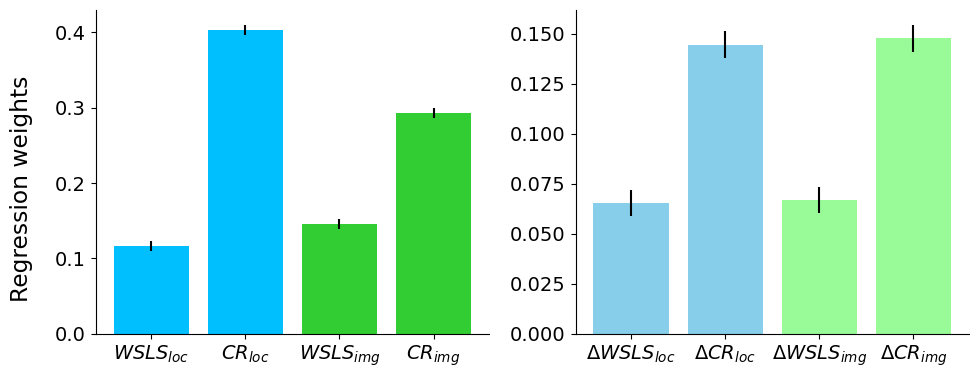

In [100]:
fig, axes = plt.subplots(1,2, figsize=(10, 4))

axes[0].bar(np.arange(4), mdl.params.iloc[[4,2,5,3]], color=['deepskyblue', 'deepskyblue', 'limegreen', 'limegreen'])
axes[0].errorbar(np.arange(4), mdl.params.iloc[[4,2,5,3]], mdl.bse.iloc[[4,2,5,3]], 
                 ls='', color='k')
axes[0].set_xticks(np.arange(4))
axes[0].set_xticklabels([r'$WSLS_{loc}$', r'$CR_{loc}$', r'$WSLS_{img}$', r'$CR_{img}$'])


axes[1].bar(np.arange(4), mdl.params.iloc[[8,6,9,7]]*np.array([-1,-1,1,1]), color=['skyblue', 'skyblue', 'palegreen', 'palegreen'])
axes[1].errorbar(np.arange(4), mdl.params.iloc[[8,6,9,7]]*np.array([-1,-1,1,1]), mdl.bse.iloc[[8,6,9,7]], 
                 ls='', color='k')
axes[1].set_xticks(np.arange(4))
axes[1].set_xticklabels([r'$\Delta WSLS_{loc}$', r'$\Delta CR_{loc}$', r'$\Delta WSLS_{img}$', r'$\Delta CR_{img}$'])


fig.supylabel('Regression weights')
fig.tight_layout()
sns.despine()
